<a href="https://colab.research.google.com/github/javmencia/RelativeBelief/blob/BiasCalculations/RegressionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln
from scipy import stats
import time
import math

def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

In [25]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 5  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihood
    mu = pm.Deterministic("mu", pm.math.dot(X, beta))
    y_ = pm.MvNormal('y_', mu=mu, cov= (sigma0**2)*np.eye(n), shape = n)

    # Prior log-probability
    prior_pd = pm.Deterministic("prior_pd", pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2)*np.eye(n), shape=(n,)), mu).sum())

    # Posterior mean and covariance for beta
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
    print(cov_beta_post)
    mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, y)) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))
    print(mean_beta_post)

    # Posterior log-probability
    posterior_beta = pm.MvNormal('posterior_beta', mu=mean_beta_post, cov=cov_beta_post)
    posterior_pd = pm.Deterministic("posterior_pd", pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_beta), cov=(sigma0**2)*np.eye(n), shape=(n, )), mu).sum())

    # Log BR
    logRB_prior_pd = pm.Deterministic("logRB_prior_pd", posterior_pd - prior_pd)

    # Likelihood
    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2)*np.eye(n), shape=n), y_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

y [-1.79012479  2.21185968 -1.25815071  1.17736163 -4.2945368 ]
[[0.29291355 0.07587258]
 [0.07587258 0.24130825]]
[1.42876204 1.85361641]


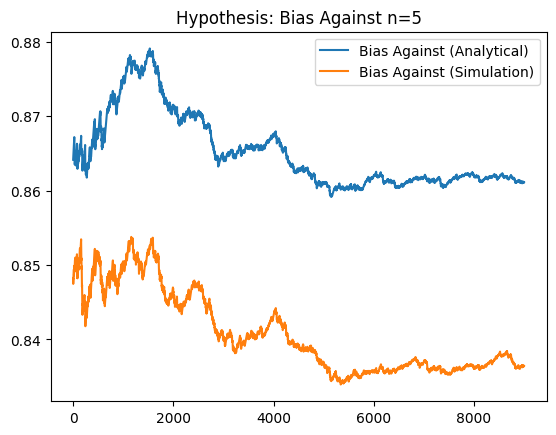

In [27]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logRB_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

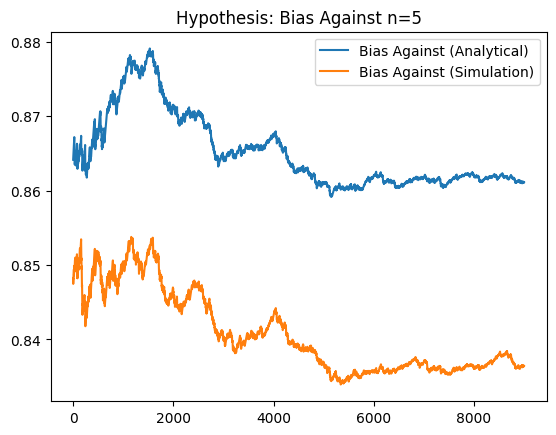

In [26]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logRB_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

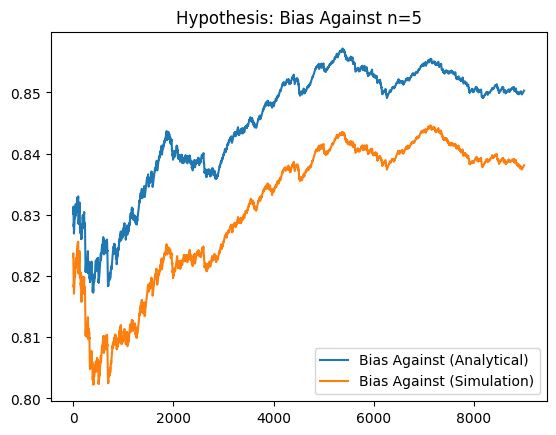

In [24]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logRB_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()